In [30]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [31]:
number_epochs = 51
batch_size = 128
learning_rate = 0.0001

transform_image = transforms.Compose([transforms.ToTensor(), ])

dataset = MNIST('/tmp/data', download=True, transform=transform_image)
data_loader = DataLoader(dataset, batch_size=batch_size, num_workers=10, shuffle=True)

(torch.Size([128, 1, 28, 28]), tensor(0.), tensor(1.))

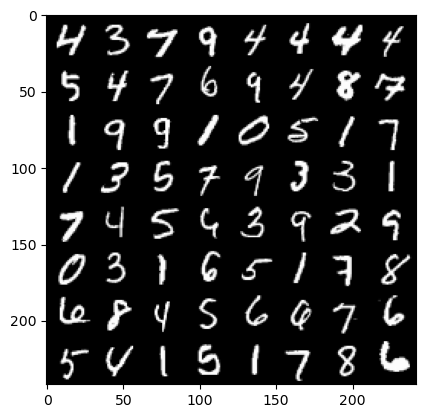

In [35]:
for images, labels in data_loader:
    break

plt.imshow(np.transpose(torchvision.utils.make_grid(images[:64]), (1,2,0)))
images.shape, images.min(), images.max()

In [36]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(True),
            nn.Linear(256, 64),
            nn.ReLU(True), nn.Linear(64, 16), nn.ReLU(True), nn.Linear(16, 2))
        self.decoder = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(True),
            nn.Linear(16, 64),
            nn.ReLU(True),
            nn.Linear(64, 256),
            nn.ReLU(True), nn.Linear(256, 28 * 28), nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Autoencoder()
model = model.to(device)

criterion = nn.MSELoss()
#criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [39]:
for image, labels in data_loader:
    break

In [40]:
image.view(image.size(0), -1).shape

torch.Size([128, 784])

In [38]:
def to_image(x):
    #x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

In [41]:
with tqdm(range(number_epochs)) as iterator:
    for epoch in iterator:
        for data in data_loader:
            optimizer.zero_grad()
            
            image, i = data
            image = image.to(device)
            
            image = image.view(image.size(0), -1)
            image = Variable(image)

            # Forward pass
            output = model(image)
            loss = criterion(output, image)

            # Backward pass
            loss.backward()
            optimizer.step()

        iterator.set_postfix_str(f"Loss:{loss.item():.4f}")
        if epoch % 10 == 0:
            pic = to_image(output.cpu().data)
            save_image(pic, f"image_{epoch}.png")

  0%|          | 0/51 [00:00<?, ?it/s]

In [42]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, device=None):
        super(VariationalAutoencoder, self).__init__()

        if device is None:
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.device = device

        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(True),
            nn.Linear(256, 64),
            nn.ReLU(True), nn.Linear(64, 16), nn.ReLU(True))
        self.mu = nn.Linear(16, 2)
        self.logvar = nn.Linear(16, 2)
        self.decoder = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(True),
            nn.Linear(16, 64),
            nn.ReLU(True),
            nn.Linear(64, 256),
            nn.ReLU(True), nn.Linear(256, 28 * 28), nn.Sigmoid())

  

    def encode_function(self, x):
        h1 = self.encoder(x)
        return self.mu(h1), self.logvar(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.FloatTensor(std.size()).normal_().to(device)
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode_function(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode_function(x)
        z = self.reparametrize(mu, logvar)
        return self.decode_function(z), mu, logvar


In [43]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = VariationalAutoencoder()
model = model.to(device)

reconstruction_loss = nn.MSELoss()

def loss_function(reconstruction_x, x, mu, latent_log_variance):
    """
    reconstruction_x: generating images
    x: original images
    mu: latent mean
    """
    RL = reconstruction_loss(reconstruction_x, x)  
    
    # KL loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_aspect = mu.pow(2).add_(latent_log_variance.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_aspect).mul_(-0.5)
    # KL divergence
    return RL + KLD

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [44]:
with tqdm(range(number_epochs)) as iterator:
    for epoch in iterator:
        for data in data_loader:
            optimizer.zero_grad()
            
            image, i = data
            image = image.to(device)
            
            image = image.view(image.size(0), -1)
            image = Variable(image)

            # Forward pass
            output, mu, logvar = model(image)
            loss = loss_function(output, image, mu, logvar)

            # Backward pass
            loss.backward()
            optimizer.step()

        iterator.set_postfix_str(f"Loss:{loss.item():.4f}")
        if epoch % 10 == 0:
            pic = to_image(output.cpu().data)
            save_image(pic, f"image_{epoch}.png")

  0%|          | 0/51 [00:00<?, ?it/s]